In [394]:
%load_ext autoreload
%autoreload 2
from data_analytics import LogAnalyzer
from data_analytics import PlotterBase
import numpy as np
import pandas as pd
from data_analytics import save_fig
from data_analytics import TIME_FORMAT
from data_analytics import readlines
import seaborn as sns
import matplotlib
import datetime
import glob
import os
import re
from collections import defaultdict
font = {'family' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

matplotlib.rcParams.update({'font.size': 16})

def parse_madlib_line(line):
    _, info, timestamp = [x.strip() for x in line.split(': ')]
    timestamp = timestamp.split('(')[0].strip()
    time_obj = datetime.datetime.strptime(timestamp, TIME_FORMAT)
#     info = re.sub("\d", "", info)
    return info, time_obj, timestamp

# Between-Start MOP training epoch-1 subepoch-0-End fit_transition training
def parse_standalone_line(line):
    splitted = line.split(', ')
    splitted = [x.split(': ') for x in splitted]
    splitted = [x for x in splitted if len(x) == 2]
    info_dict = dict(splitted)

    info = info_dict['EVENT']
    time_obj = datetime.datetime.fromtimestamp(int(info_dict['TIME']))
    timestamp = info_dict['TIME']
    return info, time_obj, timestamp

def parse_events(lines, method):
    events = []
    parse = parse_standalone_line if method == 'standalone' else parse_madlib_line
    parsed = [parse(line) for line in lines]
#     parsed = sorted(parsed, key=lambda x: x[0], reverse=True)
    parsed = sorted(parsed, key=lambda x: x[1])
    info1, time_obj1, _ = parsed[0]
    for parsed_line in parsed[1:]:
        info2, time_obj2, _ = parsed_line
        event = "Between-{}-{}".format(info1, info2)
        time_diff = (time_obj2 - time_obj1).total_seconds()
        events.append({'event':event, 'time':time_diff})
        info1, time_obj1 = info2, time_obj2
    df_events = pd.DataFrame(events)
    return df_events


def parse_all_events(la, segs=None, method=None):
    if not segs:
        segs = range(8)
    df_events_list = []
    for i in segs:
        try:
            lines = readlines(os.path.join(la.exp_root, 'client.log'))
        except:
            lines = readlines(os.path.join(la.exp_root, 'scheduler.log'))
        lines_filtered = []
        if method != 'standalone':
            for x in lines:
                if x != '':
                    if 'seg{}'.format(i) in x:
                        lines_filtered.append(x)
#                     elif 'seg' not in x and method == 'udaf' and 'End MOP' in x and 'INFO: ' in x:
#                         lines_filtered.append(x)
        else:
            lines_filtered = lines_filtered = [x for x in lines if x != '' and 'WORKER: {}'.format(i) in x]
        lines = lines_filtered
        df_events = parse_events(lines, method)
        df_events_list.append(df_events)
    df_events_grand = pd.concat(df_events_list, ignore_index=True)
    return df_events_grand
class FakeLA:
    def __init__(self, exp_root):
        self.exp_root = exp_root
def get_plot_time(la, segs, semantics, method):
    df_events_grand = parse_all_events(la, segs, method)
    df_propotion_time = df_events_grand.groupby('event').agg('sum').reset_index()[['event', 'time']]
    dict_time = dict(df_propotion_time.to_dict(orient='split')['data'])
    plot_time = {}
    for k, v in dict_time.items():
        scheme = semantics[k]
        if scheme in plot_time:
            plot_time[scheme] += v
        else:
            plot_time[scheme] = v
    return plot_time, dict_time
methods = ['Cerebro-Spark', 'MA', 'UDAF', 'CTQ', 'DA']
methods_dict = {'Cerebro-Spark':'spark', 'MA':'ma', 'UDAF':'udaf', 'CTQ':'ctq', 'DA':'da'}
e2e_methods_dict = {'ma': 'MA', 'udaf': 'UDAF', 'ctq': 'CTQ', 'da': 'DA', 'filesystem':'Cerebro-Spark'}
e2e_methods_dict_reverse = {'Cerebro-Spark':'filesystem', 'MA':'ma', 'UDAF':'udaf', 'CTQ':'ctq', 'DA':'da'}

ordered_methods_indices = [methods_dict[x] for x in methods]
INITILAIZATION = 'initialization'
NONE = 'None'
EXITING = 'exiting'
DATA_TRANSMISSION = 'data_transmission'
IDLE = 'idle'
TRAIN_VALID = 'train_valid'
MOP = 'model_hopping'
MERGE = 'merge'
FINAL = 'final'
semantics = {
    'ctq':{
    'Between-End fit_transition clearing-End inside fit_transition': EXITING,
 'Between-End fit_transition initialization-Start fit_transition training': INITILAIZATION,
'Between-End fit_transition model hopping-End fit_transition initialization': INITILAIZATION,
 'Between-End fit_transition training-Start fit_transition clearing': EXITING,
 'Between-End inside fit_transition-Start inside fit_transition': DATA_TRANSMISSION,
'Between-End inside fit_transition-Start inside internal_keras_eval_transition': IDLE,
 'Between-End inside internal_keras_eval_transition-Start inside fit_transition': IDLE,
 'Between-End inside internal_keras_eval_transition-Start inside internal_keras_eval_transition': DATA_TRANSMISSION,
 'Between-End internal_keras_eval_transition evaluate-End inside internal_keras_eval_transition': EXITING,
 'Between-End internal_keras_eval_transition initialization-Start internal_keras_eval_transition evaluate': INITILAIZATION,
 'Between-End internal_keras_eval_transition model hopping-End internal_keras_eval_transition initialization': INITILAIZATION,
 'Between-Start fit_transition clearing-End fit_transition clearing': EXITING,
 'Between-Start fit_transition initialization-End fit_transition initialization': INITILAIZATION,
 'Between-Start fit_transition initialization-Start fit_transition model hopping': INITILAIZATION,
 'Between-Start fit_transition model hopping-End fit_transition model hopping': MOP,
 'Between-Start fit_transition training-End fit_transition training': TRAIN_VALID,
 'Between-Start inside fit_transition-Start fit_transition initialization': INITILAIZATION,
 'Between-Start inside internal_keras_eval_transition-Start internal_keras_eval_transition initialization': INITILAIZATION,
 'Between-Start internal_keras_eval_transition evaluate-End internal_keras_eval_transition evaluate': TRAIN_VALID,
 'Between-Start internal_keras_eval_transition initialization-End internal_keras_eval_transition initialization': INITILAIZATION,
 'Between-Start internal_keras_eval_transition initialization-Start internal_keras_eval_transition model hopping': INITILAIZATION,
    'Between-Start internal_keras_eval_transition model hopping-End internal_keras_eval_transition model hopping': MOP
    },
    'ma':{
        'Between-End fit_transition clearing-End inside fit_transition':EXITING,
 'Between-End fit_transition initialization-Start fit_transition training':INITILAIZATION,
 'Between-End fit_transition training-Start fit_transition clearing':EXITING,
 'Between-End inside fit_transition-Start inside fit_transition':DATA_TRANSMISSION,
 'Between-End inside fit_transition-Start inside internal_keras_eval_transition':MERGE,
 'Between-End inside internal_keras_eval_transition-Start inside fit_transition':MERGE,
 'Between-End inside internal_keras_eval_transition-Start inside internal_keras_eval_transition':DATA_TRANSMISSION,
 'Between-End internal_keras_eval_transition evaluate-End inside internal_keras_eval_transition':EXITING,
 'Between-End internal_keras_eval_transition initialization-Start internal_keras_eval_transition evaluate':INITILAIZATION,
 'Between-Start fit_transition clearing-End fit_transition clearing':EXITING,
 'Between-Start fit_transition initialization-End fit_transition initialization':INITILAIZATION,
 'Between-Start fit_transition training-End fit_transition training':TRAIN_VALID,
 'Between-Start inside fit_transition-Start fit_transition initialization':INITILAIZATION,
 'Between-Start inside internal_keras_eval_transition-Start internal_keras_eval_transition initialization':INITILAIZATION,
 'Between-Start internal_keras_eval_transition evaluate-End internal_keras_eval_transition evaluate':TRAIN_VALID,
 'Between-Start internal_keras_eval_transition initialization-End internal_keras_eval_transition initialization':INITILAIZATION
    },
    'udaf':{
        'Between-End fit_transition clearing-End inside fit_transition':EXITING,
 'Between-End fit_transition initialization-Start fit_transition training':INITILAIZATION,
 'Between-End fit_transition training-Start fit_transition clearing':EXITING,
 'Between-End inside fit_transition-Start inside fit_transition':DATA_TRANSMISSION,
 'Between-End inside fit_transition-Start inside internal_keras_eval_transition':MOP,
 'Between-End inside internal_keras_eval_transition-Start inside internal_keras_eval_transition':DATA_TRANSMISSION,
 'Between-End internal_keras_eval_transition evaluate-End inside internal_keras_eval_transition':EXITING,
 'Between-End internal_keras_eval_transition initialization-Start internal_keras_eval_transition evaluate':INITILAIZATION,
 'Between-Start fit_transition clearing-End fit_transition clearing':EXITING,
 'Between-Start fit_transition initialization-End fit_transition initialization':INITILAIZATION,
 'Between-Start fit_transition training-End fit_transition training':TRAIN_VALID,
 'Between-Start inside fit_transition-Start fit_transition initialization':INITILAIZATION,
 'Between-Start inside internal_keras_eval_transition-Start internal_keras_eval_transition initialization':INITILAIZATION,
 'Between-Start internal_keras_eval_transition evaluate-End internal_keras_eval_transition evaluate':TRAIN_VALID,
 'Between-Start internal_keras_eval_transition initialization-End internal_keras_eval_transition initialization':INITILAIZATION,
        'Between-End inside internal_keras_eval_transition-Start inside fit_transition':IDLE
    },
    'ctq_old':{'Between-End fit_transition clearing-End inside fit_transition':INITILAIZATION,
 'Between-End fit_transition initialization-Start fit_transition training':INITILAIZATION,
 'Between-End fit_transition training-Start fit_transition clearing':EXITING,
 'Between-End inside fit_transition-Start inside fit_transition':DATA_TRANSMISSION,
 'Between-End inside fit_transition-Start inside internal_keras_eval_transition':DATA_TRANSMISSION,
 'Between-End inside internal_keras_eval_transition-Start inside fit_transition':IDLE,
 'Between-End inside internal_keras_eval_transition-Start inside internal_keras_eval_transition':DATA_TRANSMISSION,
 'Between-End internal_keras_eval_transition evaluate-End inside internal_keras_eval_transition':EXITING,
 'Between-End internal_keras_eval_transition initialization-Start internal_keras_eval_transition evaluate':INITILAIZATION,
 'Between-Start fit_transition clearing-End fit_transition clearing':EXITING,
 'Between-Start fit_transition initialization-End fit_transition initialization':INITILAIZATION,
 'Between-Start fit_transition training-End fit_transition training':TRAIN_VALID,
 'Between-Start inside fit_transition-Start fit_transition initialization':INITILAIZATION,
 'Between-Start inside internal_keras_eval_transition-Start internal_keras_eval_transition initialization':INITILAIZATION,
 'Between-Start internal_keras_eval_transition evaluate-End internal_keras_eval_transition evaluate':TRAIN_VALID,
 'Between-Start internal_keras_eval_transition initialization-End internal_keras_eval_transition initialization':INITILAIZATION},
    'standalone':{
        'Between-PRELOAD_COMPLETED-TRAIN_LAUNCHED': IDLE,
        'Between-TRAIN_COMPLETED-TRAIN_LAUNCHED': IDLE,
        'Between-TRAIN_COMPLETED-VALID_LAUNCHED': IDLE,
        'Between-TRAIN_LAUNCHED-TRAIN_COMPLETED': TRAIN_VALID,
        'Between-VALID_COMPLETED-VALID_LAUNCHED': IDLE,
        'Between-VALID_LAUNCHED-VALID_COMPLETED': TRAIN_VALID,
        'Between-VALID_COMPLETED-TRAIN_LAUNCHED': IDLE
    }
    
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Trade-off plots

In [341]:
%load_ext autoreload
%autoreload 2
from data_analytics import LogAnalyzer
from data_analytics import PlotterBase

from data_analytics import save_fig
import matplotlib as mpl
import seaborn as sns
palette = sns.color_palette("hls", 5)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=palette)
matplotlib.rcParams.update({'font.size': 20})


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [342]:
methods

['Cerebro-Spark', 'MA', 'UDAF', 'CTQ', 'DA']

In [352]:
?PlotterBase

[Text(0, 0, 'Low'), Text(0, 0, 'Mid'), Text(0, 0, 'High')]

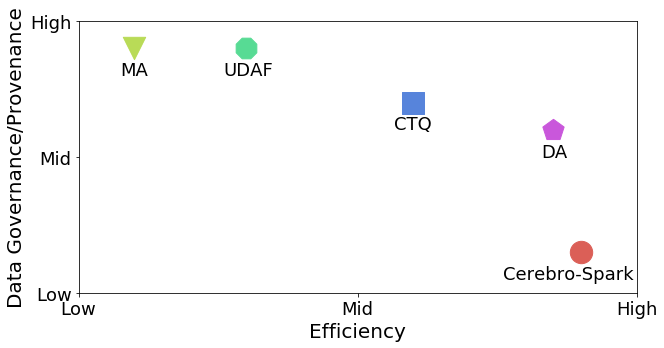

In [392]:
points = [
    [9, 1.5], 
    [1, 9], 
    [3, 9], 
    [6, 7], 
    [8.5, 6]
]
text_poses = [
    [7.6, 0.5], 
    [0.75, 8.0], 
    [2.6, 8.0], 
    [5.65, 6.0], 
    [8.3, 5]
]

plot_trade_off = PlotterBase(xlabel='Efficiency', ylabel='Data Governance/Provenance', set_ticks=False, figsize=(10, 5))
makers = ['o', 'v', '8', 's', 'p']
delta = 0.1
for method, point, marker, text_pos in zip(methods, points, makers, text_poses):
    plot_trade_off.ax.scatter(point[0], point[1], s=500, label=method, marker=marker)
    plot_trade_off.ax.text(text_pos[0], text_pos[1], method, fontsize=18)
plot_trade_off.ax.set_xticks([0, 5, 10])  
plot_trade_off.ax.set_xticklabels(['Low', 'Mid', 'High'], fontsize=18)
plot_trade_off.ax.set_yticks([0, 5, 10])  
plot_trade_off.ax.set_yticklabels(['Low', 'Mid', 'High'], fontsize=18)

In [393]:
save_fig(plot_trade_off.fig, '2d_trade_offs')

### End to End


In [263]:
methods

['Cerebro-Spark', 'MA', 'UDAF', 'CTQ', 'DA']

#### ImageNet

In [230]:
%load_ext autoreload
%autoreload 2
from data_analytics import LogAnalyzer
from data_analytics import PlotterBase

from data_analytics import save_fig
import matplotlib as mpl
import seaborn as sns
palette = sns.color_palette("hls", 5)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=palette)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [231]:
methods

['Cerebro-Spark', 'MA', 'UDAF', 'CTQ', 'DA']

Method: filesystem
Total time: 22.8825 hrs
Original time: 2020-08-12 17:22:58 to 2020-08-13 16:15:55
Shifted time: 2020-08-12 17:22:58 to 2020-08-13 16:15:55
gpu_utilization_worker5.log
gpu_utilization_worker6.log
gpu_utilization_worker1.log
gpu_utilization_worker2.log
gpu_utilization_worker4.log
gpu_utilization_worker3.log
gpu_utilization_worker0.log
gpu_utilization_worker7.log
Average GPU utilization: 70.11867662776841 %
Method: ma
Total time: 42.61416666666667 hrs
Original time: 2020-04-23 01:31:43 to 2020-04-24 20:08:34
Shifted time: 2020-04-23 01:31:43 to 2020-04-24 20:08:34
gpu_utilization_worker5.log
gpu_utilization_worker6.log
gpu_utilization_worker1.log
gpu_utilization_worker2.log
gpu_utilization_worker4.log
gpu_utilization_worker3.log
gpu_utilization_worker0.log
gpu_utilization_worker7.log
Average GPU utilization: 56.809983179690974 %
Method: udaf
Total time: 48.528888888888886 hrs
Original time: 2020-04-24 22:05:00 to 2020-04-26 22:36:44
Shifted time: 2020-04-24 22:05:00 to 

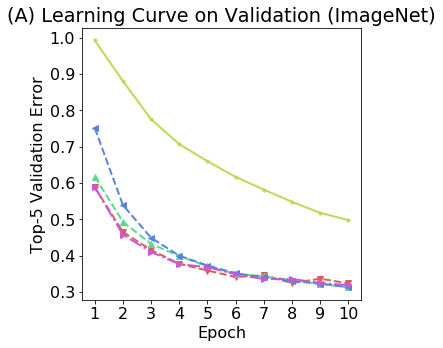

In [232]:
log_dirs_all = {
    'ma': {
        'log_root': '/local/cerebro-greenplum/logs',
        'gpu_logs': 'gpu_logs',
        'cpu_logs': 'cpu_logs',
        'timestamp': '2020_04_23_01_31_43',
        'timestamp_db': '2020_04_23_01_32_31',
        'num_models': 16,
        'method': 'ma',
        'exp_name': 'gp_ma_baseline_modified_buffer_2020_04_23_01_32_31'
    },
    'udaf': {
        'log_root': '/local/cerebro-greenplum/logs',
        'gpu_logs': 'gpu_logs',
        'cpu_logs': 'cpu_logs',
        'timestamp': '2020_04_24_22_05_00',
        'timestamp_db': '2020_04_24_22_05_04',
        'num_models': 16,
        'method': 'udaf',
        'exp_name': 'gp_cerebro_modified_buffer_2020_04_24_22_05_04'
    },
    'ctq': {
        'log_root': '/local/cerebro-greenplum/logs',
        'gpu_logs': 'gpu_logs_july_august',
        'cpu_logs': 'cpu_logs_july_august',
        'timestamp': '2020_08_18_16_47_28',
        'method': 'ctq',
        'exp_name': 'cerebro-ctq'
    },
    'da': {
        'log_root': '/local/cerebro-greenplum/logs',
        'gpu_logs': 'gpu_logs_july_august',
        'cpu_logs': 'cpu_logs_july_august',
        'timestamp': '2020_08_14_16_08_52',
        'method': 'da',
        'exp_name': 'e2e_da_cerebro_standalone'
    },
    'filesystem': {
        'log_root': '/local/cerebro-greenplum/logs',
        'gpu_logs': 'gpu_logs_july_august',
        'cpu_logs': 'cpu_logs_july_august',
        'timestamp': '2020_08_12_17_22_58',
        'method': 'filesystem',
        'exp_name': 'e2e_filesystem_cerebro_standalone'
    }}

plot_e2e = PlotterBase(xlabel='Epoch', ylabel='Top-5 Validation Error', title='(A) Learning Curve on Validation (ImageNet)', set_ticks=True)
line_fmts = ['v--',  '.-', '^--', '<--', '>-.' ]
la_dict = {}
for method, fmt in list(zip(methods, line_fmts)):
    method_name_e2e = e2e_methods_dict_reverse[method]
    log_dirs = log_dirs_all[method_name_e2e]
    df_grand_list = []
    
    la = LogAnalyzer(find_first=True, **log_dirs)
    la_dict[method] = la
    shift = 2.6 * 3600 if method_name_e2e == 'da' else 0
    method_reported, total_time, avg_gpu_utilization, x, y, df_grand = la.report(shift=shift)
    plot_e2e.plot(x, y, fmt, label=method)
    

In [233]:
plot_e2e.ax.legend(ncol=1, fontsize=14)

In [234]:
# plot_e2e.fig.tight_layout()

In [235]:
plot_e2e.ax.set_title('(A) Learning Curve on Validation (ImageNet)', fontsize=14)

Text(0.5, 1.0, '(A) Learning Curve on Validation (ImageNet)')

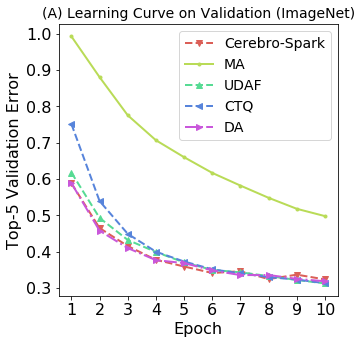

In [236]:
plot_e2e.fig

In [238]:
plot_e2e.save('e2e')

In [61]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# df_plot = pd.DataFrame([x[0:3] for x in grand_list], columns=['method', 'runtime', 'gpu_utilization'])

# index = np.arange(len(df_plot))

# df_plot['runtime'] /= 10

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
# bar_width = 0.2
# ax.barh(index, df_plot['runtime'], bar_width,color='#C14953',label=r'Runtime hr/epoch',hatch='//')
# ax.barh(index+bar_width, df_plot['gpu_utilization'],bar_width,color='#E5DCC5',label=r'Panorama $a_g=0.99$',hatch='\\')


#### Criteo

In [116]:
%load_ext autoreload
%autoreload 2
from data_analytics import LogAnalyzer
from data_analytics import PlotterBase

from data_analytics import save_fig
import matplotlib as mpl
import seaborn as sns
palette = sns.color_palette("hls", 5)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=palette)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The sql extension is already loaded. To reload it, use:
  %reload_ext sql
DA
Method: da
Total time: 23.580555555555556 hrs
Original time: 2020-10-14 03:31:04 to 2020-10-15 03:05:54
Shifted time: 2020-10-14 05:25:04 to 2020-10-15 03:05:54
cpu_utilization_worker5.log
cpu_utilization_worker6.log
cpu_utilization_worker0.log
cpu_utilization_worker1.log
cpu_utilization_worker4.log
cpu_utilization_worker3.log
cpu_utilization_worker2.log
cpu_utilization_worker7.log
Average CPU utilization: 37.045118052806444 %
Original time: 2020-10-14 03:31:04 to 2020-10-15 03:05:54
Shifted time: 2020-10-14 03:31:04 to 2020-10-15 03:05:54
cpu_utilization_worker5.log
cpu_utilization_worker6.log
cpu_utilization_worker0.log
cpu_utilization_worker1.log
cpu_utilization_worker4.log
cpu_utilization_worker3.log
cpu_utilization_worker2.log
cpu_utilization_worker7.log
Average CPU utilization: 34.26171238909983 %
CTQ
Method: ctq
Total time: 41.11611111111111 hrs
Original time: 2020-10-19 18:33:55 to 2020-10-21 11:40:53


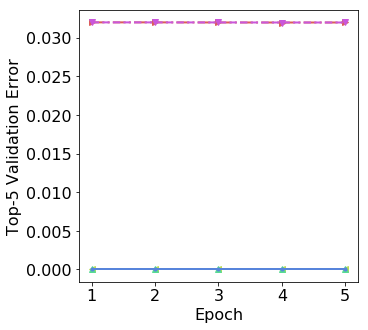

In [121]:
log_dirs_all = {
    'ma': {
        'log_root': '/local/cerebro-greenplum/logs',
        'gpu_logs': None,
        'cpu_logs': 'cpu_logs_october',
        'timestamp': '2020_10_21_13_58_50',
        'timestamp_db': '2020_10_21_13_59_04',
        'num_models': 16,
        'method': 'ma',
        'exp_name': 'ma'
    },
    'udaf': {
        'log_root': '/local/cerebro-greenplum/logs',
        'gpu_logs': None,
        'cpu_logs': 'cpu_logs_october',
        'timestamp': '2020_10_15_10_54_12',
        'timestamp_db': '2020_10_15_10_54_30',
        'num_models': 16,
        'method': 'udaf',
        'exp_name': 'cerebro'
    },
    'ctq': {
        'log_root': '/local/cerebro-greenplum/logs',
        'gpu_logs': None,
        'cpu_logs': 'cpu_logs_october',
        'timestamp': '2020_10_19_18_33_55',
        'method': 'ctq',
        'exp_name': 'cerebro-ctq'
    },
    'da': {
        'log_root': '/local/cerebro-greenplum/logs',
        'gpu_logs': None,
        'cpu_logs': 'cpu_logs_october',
        'timestamp': '2020_10_14_03_31_04',
        'method': 'da',
        'exp_name': 'cerebro-da'
    },
    'filesystem': {
        'log_root': '/local/cerebro-greenplum/logs',
        'gpu_logs': None,
        'cpu_logs': 'cpu_logs_october',
        'timestamp': '2020_10_18_04_02_57',
        'method': 'filesystem',
        'exp_name': 'e2e_filesystem_cerebro_standalone'
    }}

plot_e2e = PlotterBase(xlabel='Epoch', ylabel='Top-5 Validation Error', set_ticks=True)
line_fmts = ['v--', '.-', '^--', '<--', '>-.' ]
la_dict = {}
for method, fmt in list(zip(methods, line_fmts))[::-1]:
    print(method)
    method_name_e2e = e2e_methods_dict_reverse[method]
    log_dirs = log_dirs_all[method_name_e2e]
    df_grand_list = []
    la = LogAnalyzer(find_first=True, **log_dirs)
    la_dict[method] = la
    total_time = la.report_runtimes()
    if method_name_e2e == 'da':
#         shift off the ETL portion
        avg_cpu_utilization = la.report_cpu_tuilization(shift = 1.9*3600)
    avg_cpu_utilization = la.report_cpu_tuilization()
    df_grand, x, y = la.get_learning_curve(top_5=False)
#     method_reported, total_time, avg_gpu_utilization, x, y, df_grand = la.report()
    plot_e2e.plot(x, y, fmt, label=method)
    

In [12]:
# from data_analytics import SystemLogAnalyzer

# workers_utilizations = []
# for logfile_dir in os.listdir(sa.logs_root):

#     if 'worker' not in logfile_dir:
#         continue
#     print(logfile_dir)
#     lines = readlines(os.path.join(sa.logs_root, logfile_dir))
#     worker_utilizations = sa.parse(lines, logfile_dir)

#     workers_utilizations.append(np.mean(worker_utilizations))

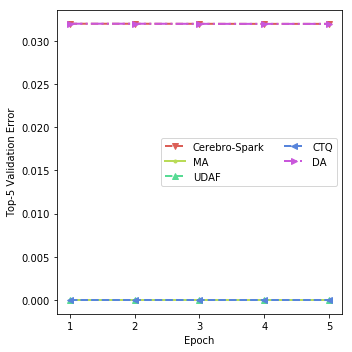

In [11]:
plot_e2e.fig

### MOP-MA Hybrid

In [184]:
palette = sns.color_palette("hls", 11)
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=palette)

In [185]:
import os
import glob
import re
import pandas as pd

def read_history(path):
    with open(path, 'rb') as f:
        history = dill.load(f, encoding="latin1")
    return history

class args:
    models_root = '/mnt/nfs/models/single_node_imagenet'
    ma_model_dir_prefix = 'ma'
    sequential_dir_prefix = 'sequential'
    sequential_history_name = 'history_trained-10_initial-0_partition-a.pickle'

ma_root = os.path.join(args.models_root, args.ma_model_dir_prefix)
sequential_root = os.path.join(args.models_root, args.sequential_dir_prefix)
sequential_history_path =  os.path.join(sequential_root, args.sequential_history_name)
sequential_history = read_history(sequential_history_path)

ma_histories_paths = glob.glob(ma_root + '/*/*.pickle')
ma_histories_paths = [x for x in ma_histories_paths if 'trained-10' in x]

df_sequential = pd.DataFrame(sequential_history)

ma_history = {}
ma_histories_plot = {}
ma_partition_histories = {}
ma_global_histories = {}
for path in ma_histories_paths:
    match = re.search('initial-(\d+)', path)
    initial = match.group(1)
    ma_history[initial] = read_history(path)



In [186]:
ma_partition_histories_list = []
ma_global_histories_list = []
ma_global_histories_dict = defaultdict(dict)
full_histories = {}
for initial, history in ma_history.items():
    initial = int(initial)
    global_histories = history['global_histories']
    for epoch, history in global_histories.items():
        ma_global_histories_dict[initial][epoch] = history
    full_history_list = []
    for i in range(initial, 10):
        history = global_histories[i]
        full_history_list.append(history['top_k_categorical_accuracy'])
    full_histories[initial] = full_history_list

sequential_list = list(df_sequential['val_top_k_categorical_accuracy'])
for initial, history in ma_global_histories_dict.items():
    sequential_part = list(df_sequential['val_top_k_categorical_accuracy'])[:initial]
    ma_part = full_histories[initial]
    full_histories[initial] = sequential_part + ma_part

<IPython.core.display.Javascript object>


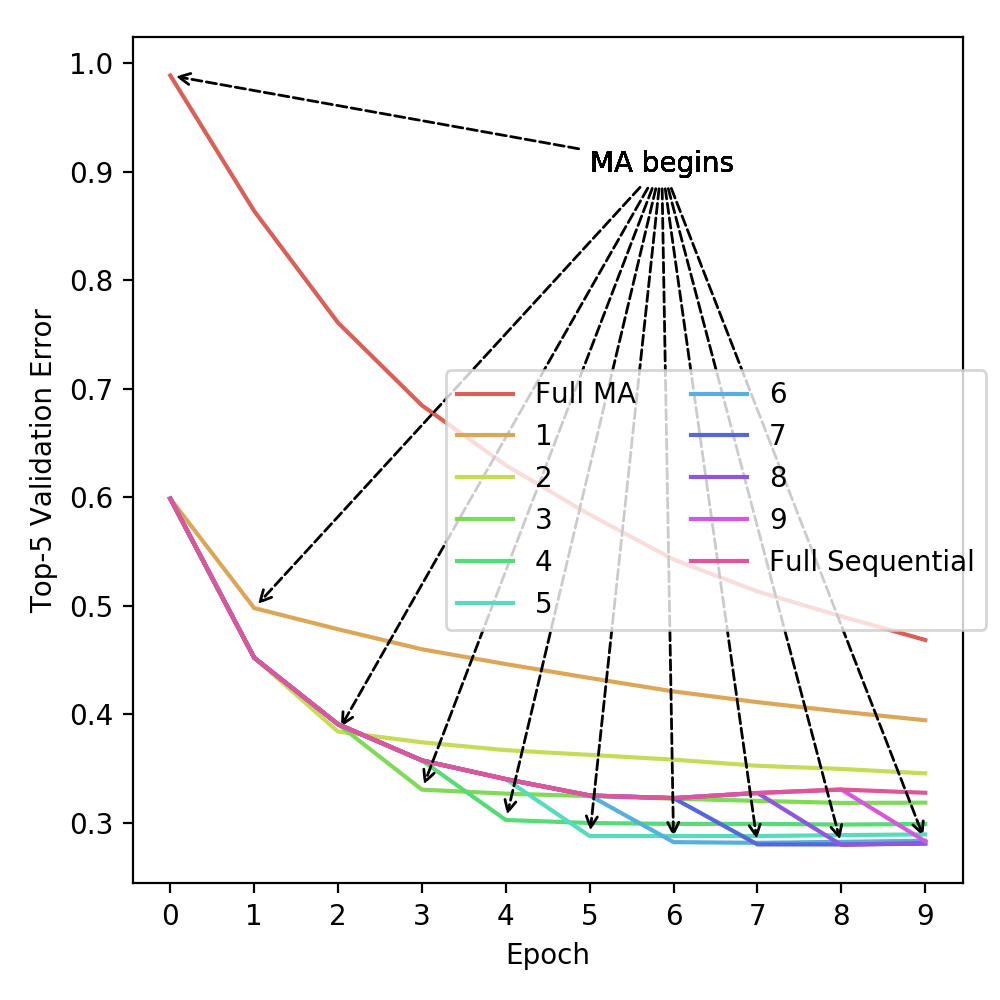

In [200]:
epochs = list(range(10))
plot_e2e = PlotterE2E()

for i in range(10):
    history = full_histories[i]
    anno = i if i != 0 else 'Full MA'
    history = 1 - np.array(history)
    plot_e2e.plot(epochs, history, anno)
    plt.annotate("MA begins", xy=(i, history[i]), xytext=(5, 0.9), arrowprops=dict(arrowstyle="->", linestyle='dashed'))
plot_e2e.plot(epochs, 1 - np.array(sequential_list), 'Full Sequential')
plot_e2e.conclude()

### Model size

#### ImageNet

In [48]:
%load_ext autoreload
%autoreload 2
from data_analytics import LogAnalyzer
from data_analytics import TIME_FORMAT
import os
import datetime
import pandas as pd
import plotly.figure_factory as ff
from data_analytics import readlines
from collections import defaultdict
from matplotlib import pyplot as plt
import matplotlib
from data_analytics import save_fig
# font = {'family' : 'normal',
#         'size'   : 16}
# matplotlib.rc('font', **font)
palette = sns.color_palette("hls", 2)
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=palette)

exp_names = [
    'udaf/model_size_s',
    'udaf/model_size_m',
    'udaf/model_size_l',
    'udaf/model_size_x',
    'ctq/model_size_s',
    'ctq/model_size_m',
    'ctq/model_size_l',
    'ctq/model_size_x'
]

methods = [
    'drill_down_udaf_ctq_model_size-udaf-s',
    'drill_down_udaf_ctq_model_size-udaf-m',
    'drill_down_udaf_ctq_model_size-udaf-l',
    'drill_down_udaf_ctq_model_size-udaf-x',
    'drill_down_udaf_ctq_model_size-ctq-s',
    'drill_down_udaf_ctq_model_size-ctq-m',
    'drill_down_udaf_ctq_model_size-ctq-l',
    'drill_down_udaf_ctq_model_size-ctq-x'
]

log_dirs_all = {}
for exp_name, method in zip(exp_names, methods):
    log_dirs_all[method] = {
        "log_root": '../logs',
        'gpu_logs': 'gpu_logs_july_august',
        'cpu_logs': 'cpu_logs_july_august',
        'network_logs': 'network_logs_september',
        'timestamp': '2020_09_10_22_42_31',
        'method': method,
        'exp_name': exp_name
    }

methods_comp = methods[:4] + methods[4:]
methods_comp[::2] = methods[:4]
methods_comp[1::2] = methods[4:]


la_list = {}
for method in methods_comp:
    log_dirs = log_dirs_all[method]
    la = LogAnalyzer(find_first=False, **log_dirs)
    print("Method: {}, runtime: {}".format(method, la.get_runtimes()[-1]))
#     stats_master, stats_workers = la.report_network()
#     stats_master, stats_workers = la.network_stats_master, \
#             la.network_stats_workers
    la_list[method] = la
#     print("master stats:{}\nworkers stats:{}".format(
#                 stats_master[['rxtxkB/s']].iloc[1],
#                 stats_workers[['rxtxkB/s']].iloc[1]))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Method: drill_down_udaf_ctq_model_size-udaf-s, runtime: 5.81638888889
Method: drill_down_udaf_ctq_model_size-ctq-s, runtime: 6.65527777778
Method: drill_down_udaf_ctq_model_size-udaf-m, runtime: 7.5025
Method: drill_down_udaf_ctq_model_size-ctq-m, runtime: 8.69194444444
Method: drill_down_udaf_ctq_model_size-udaf-l, runtime: 15.5822222222
Method: drill_down_udaf_ctq_model_size-ctq-l, runtime: 15.7066666667
Method: drill_down_udaf_ctq_model_size-udaf-x, runtime: 6.82222222222
Method: drill_down_udaf_ctq_model_size-ctq-x, runtime: 7.44


In [49]:
# plot_list = []
# for msize in ['s', 'm', 'l', 'x']:
#     for mode in ['ctq', 'udaf']:
#         exp_name = 'drill_down_udaf_ctq_model_size-{}-{}'.format(mode, msize)
#         df_events_grand = parse_all_events(la_list[exp_name])
#         df_propotion_time = df_events_grand.groupby('event').agg('sum').reset_index()[['event', 'time']]
#         dict_time = dict(df_propotion_time.to_dict(orient='split')['data'])
#         plot_time = {}
#         for k, v in dict_time.items():
#             if mode == 'ctq':
#                 mode_name = 'ctq_old'
#             else:
#                 mode_name = mode
#             scheme = semantics[mode_name][k]
#             if scheme in plot_time:
#                 plot_time[scheme] += v
#             else:
#                 plot_time[scheme] = v
#         plot_time['msize'] = msize
#         plot_time['mode'] = mode
#         plot_list.append(plot_time)


# df_plot = pd.DataFrame(plot_list)
# df_plot['data_transmission'] = df_plot['data_transmission'] - df_plot.loc[(df_plot['mode']=='ctq') & (df_plot['msize'] == 's')]['data_transmission'][0]

# df_plot['model_hopping'].fillna(0, inplace=True)
# df_plot['data_transmission'] += df_plot['model_hopping']

# df_plot[['initialization', 'exiting', 'data_transmission', 'idle', 'train_valid','model_hopping']]/= (3600*8*3)

In [50]:
df_plot

,data_transmission,exiting,idle,initialization,mode,model_hopping,msize,train_valid
0,0.000000,0.001204,0.238507,0.059942,ctq,0.000000,s,1.258484
1,0.089653,0.001505,0.000868,0.060671,udaf,0.005463,s,1.225440
2,0.006817,0.002199,0.455706,0.070417,ctq,0.000000,m,1.746620
3,0.123553,0.002049,0.001065,0.071400,udaf,0.005266,m,1.738137
4,0.020417,0.005810,0.236713,0.210139,ctq,0.000000,l,4.139225
5,0.223113,0.005521,0.001655,0.223924,udaf,0.011076,l,4.136331
6,0.021435,0.001563,0.365023,0.015312,ctq,0.000000,x,1.527303
7,0.194919,0.001400,0.001840,0.009271,udaf,0.011632,x,1.511204


In [52]:
plot_list = []
for msize in ['s', 'm', 'l']:
    for mode in ['ctq', 'udaf']:
        exp_name = 'drill_down_udaf_ctq_model_size-{}-{}'.format(mode, msize)
        df_events_grand = parse_all_events(la_list[exp_name])
        df_propotion_time = df_events_grand.groupby('event').agg('sum').reset_index()[['event', 'time']]
        dict_time = dict(df_propotion_time.to_dict(orient='split')['data'])
        plot_time = {}
        for k, v in dict_time.items():
            if mode == 'ctq':
                mode_name = 'ctq_old'
            else:
                mode_name = mode
            scheme = semantics[mode_name][k]
            if scheme in plot_time:
                plot_time[scheme] += v
            else:
                plot_time[scheme] = v
        plot_time['msize'] = msize
        plot_time['mode'] = mode
        plot_list.append(plot_time)


df_plot = pd.DataFrame(plot_list)
df_plot['data_transmission'] = df_plot['data_transmission'] - df_plot.loc[(df_plot['mode']=='ctq') & (df_plot['msize'] == 's')]['data_transmission'][0]

df_plot['model_hopping'].fillna(0, inplace=True)
df_plot['data_transmission'] += df_plot['model_hopping']

df_plot[['initialization', 'exiting', 'data_transmission', 'idle', 'train_valid','model_hopping']]/= (3600*8*3)

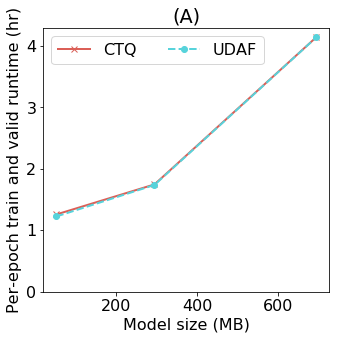

In [61]:
sizes = [52, 294, 693]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
ax.set_xlabel('Model size (MB)')
ax.set_ylabel('Per-epoch average machine time (hr)')
ax.set_title('(A) Train + Valid')
df_plot_ctq = df_plot.loc[df_plot['mode'] == 'ctq']
ax.plot(sizes, df_plot_ctq['train_valid'], 'x-', label='CTQ', linewidth=2)
df_plot_udaf = df_plot.loc[df_plot['mode'] == 'udaf']
ax.plot(sizes, df_plot_udaf['train_valid'], 'o--', label='UDAF', linewidth=2)
ax.legend(ncol=2)
ax.set_ylim(ymin=0)
fig.tight_layout()


In [62]:
save_fig(fig, "model_size_sgd_cost")

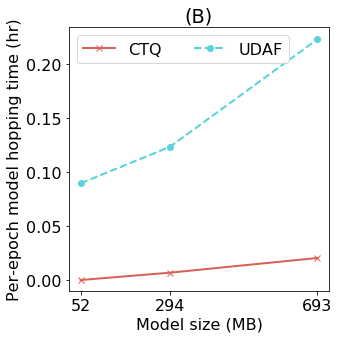

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
ax.set_xlabel('Model size (MB)')
ax.set_ylabel('Per-epoch average machine time (hr)')
ax.set_title('(B) Model Transmission')
df_plot_ctq = df_plot.loc[df_plot['mode'] == 'ctq']
ax.plot(sizes, df_plot_ctq['data_transmission'], 'x-', label='CTQ', linewidth=2)
df_plot_udaf = df_plot.loc[df_plot['mode'] == 'udaf']
ax.plot(sizes, df_plot_udaf['data_transmission'], 'o--', label='UDAF', linewidth=2)
ax.legend(ncol=2)
ax.set_ylim(ymin=-.01)
ax.set_xticks(sizes)
fig.tight_layout()

In [60]:
save_fig(fig, "model_size_mop_cost")

#### Criteo

In [45]:
%load_ext autoreload
%autoreload 2
from data_analytics import LogAnalyzer
from data_analytics import TIME_FORMAT
import os
import datetime
import pandas as pd
from data_analytics import readlines
from collections import defaultdict
from matplotlib import pyplot as plt
import matplotlib
from data_analytics import save_fig
# font = {'family' : 'normal',
#         'size'   : 16}
# matplotlib.rc('font', **font)
palette = sns.color_palette("hls", 2)
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=palette)

method_trans = {
    'cerebro':'udaf',
    'cerebro-ctq':'ctq'
}
log_dirs_all = {
    'udaf':{
        "log_root": '../logs',
        'gpu_logs': None,
        'cpu_logs': 'cpu_logs_october',
        'network_logs': None,
        'timestamp': '2020_10_23_19_52_18',
        'method': 'cerebro',
        'exp_name': 'cerebro'
    },
    'ctq':{
        "log_root": '../logs',
        'gpu_logs': None,
        'cpu_logs': 'cpu_logs_october',
        'network_logs': None,
        'timestamp': '2020_10_24_02_59_23',
        'method': 'cerebro-ctq',
        'exp_name': 'cerebro-ctq'
    }
}


la_list = {}
for method, log_dirs in log_dirs_all.items():
    la = LogAnalyzer(find_first=False, **log_dirs)
    print("Method: {}, runtime: {}".format(method, la.get_runtimes()[-1]))
#     stats_master, stats_workers = la.report_network()
#     stats_master, stats_workers = la.network_stats_master, \
#             la.network_stats_workers
    la_list[method] = la
#     print("master stats:{}\nworkers stats:{}".format(
#                 stats_master[['rxtxkB/s']].iloc[1],
#                 stats_workers[['rxtxkB/s']].iloc[1]))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Method: udaf, runtime: 7.032222222222222
Method: ctq, runtime: 8.265833333333333


In [49]:
plot_list = []
msize = 'confA'
for method, la in la_list.items():
    df_events_grand = parse_all_events(la)
    df_propotion_time = df_events_grand.groupby('event').agg('sum').reset_index()[['event', 'time']]
    dict_time = dict(df_propotion_time.to_dict(orient='split')['data'])
    plot_time = {}
    for k, v in dict_time.items():
        mode_name = method
        scheme = semantics[mode_name][k]
        if scheme in plot_time:
            plot_time[scheme] += v
        else:
            plot_time[scheme] = v
    plot_time['msize'] = msize
    plot_time['mode'] = method
    plot_list.append(plot_time)

In [58]:
df_plot = pd.DataFrame(plot_list)

df_plot['model_hopping'] += (df_plot['data_transmission'] - df_plot.loc[(df_plot['mode']=='ctq')]['data_transmission'].iloc[0])
df_plot['data_transmission'] = df_plot.loc[(df_plot['mode']=='ctq')]['data_transmission'].iloc[0]


In [60]:


df_plot[['initialization', 'exiting', 'data_transmission', 'idle', 'train_valid','model_hopping']]/= (3600*8*3)

In [61]:
df_plot

,exiting,initialization,data_transmission,model_hopping,idle,train_valid,msize,mode
0,0.000486,0.002650,0.637859,0.081667,0.000752,1.617755,confA,udaf
1,0.000637,0.002639,0.637859,0.000255,0.427789,1.617396,confA,ctq


### Gantt Chart

In [80]:
# import dill
# from IPython.display import display
# import seaborn as sns
# colors = sns.color_palette("hls", 8)
# with open('../logs/run_logs/2020_09_10_22_42_31/ctq/model_size_x/jobs_info.pkl', 'rb') as f:
#     jobs_info = dill.load(f)

# df_list = []
# for job_key, job_info in jobs_info[1].items():
#     start_time = datetime.datetime.strptime(job_info['start_time'], TIME_FORMAT)
#     end_time = datetime.datetime.strptime(job_info['end_time'], TIME_FORMAT)
#     total_time = (end_time - start_time).total_seconds()
#     init_time = job_info['init_time']
#     train_time = job_info['train_time']
#     valid_time = job_info['valid_time']
#     df_list.append({
#         "start_time":start_time, 
#         'end_time':end_time, 
#         'total_time':total_time, 
#         'init_time':init_time, 'train_time':train_time, 
#         'valid_time':valid_time, 
#         'worker_number':int(job_key[1]),
#         'model_name':job_key[0]
#     })

# df_jobs = pd.DataFrame(df_list)
# df_jobs = df_jobs.sort_values('start_time').reset_index()




# with pd.option_context('display.max_rows', 100, 'display.max_columns', 10):
#     display(df_jobs)

# df_grand = df_jobs
# time_zero = df_grand['start_time'].min()
# time_max = df_grand['start_time'].max()

# for name in ['start_time', 'end_time']:
#     df_grand[name] = (df_grand[name] - time_zero).dt.total_seconds()/3600

# df_grand['Task'] = df_grand['worker_number']
# df_grand['Start'] = df_grand['start_time']
# df_grand['Finish'] = df_grand['end_time']

# model_names = list(df_grand['model_name'].unique())

# gannt chart
# df_plot = df_grand.sort_values('Task')
# font_size = 14

# start_point = df_plot['Start'].min()
# df_plot['Start']  = df_plot['Start'] - start_point
# df_plot['Finish']  = df_plot['Finish'] - start_point

# annots = []
# for i, row in df_plot.iterrows():
#     mid_point = ((row['Start'] + (row['Finish'] - row['Start'])/2))
#     obj = dict(
#         x=mid_point,
#         y=7 - int(row['worker_number']),
#         text="{}".format(model_names.index(row['model_name'])),
#         showarrow=False,
#         font=dict(color='white', size=int(font_size * 0.7)))
#     annots.append(obj)
    
    
    



# fig = ff.create_gantt(df_plot,
#                       colors=colors,
#                       index_col='model_name',
#                       show_colorbar=False,
#                       group_tasks=True, title=None)
# fig['layout']['xaxis'].update({'type': None})
# fig['layout']['xaxis']['title'] = 'time/hr'
# fig['layout']['xaxis']['tickfont']['size'] = font_size
# fig['layout']['yaxis']['tickfont']['size'] = font_size
# fig['layout']['xaxis']['title']['font']['size'] = font_size
# fig['layout']['font']['size'] = font_size
# fig['layout']['annotations'] = annots
# fig['layout']['plot_bgcolor'] = 'rgba(0,0,0,0)'

# W0 0     1 2 3
# W1 1 3 2   0
# W2 2 1 3     0
# W3 3 2 1 0
# 2(M - 1)

### Scalability

In [409]:
palette = sns.color_palette("hls", 5)
matplotlib.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=palette)

size = [1, 2, 4, 8]
times = {
    'Cerebro-Spark': [26274.0, 10576.32, 5415.02, 3251.20],
    'MA': [64898, 32966, 17181, 9190],
    'UDAF': [65268, 32932, 17029, 8841],
    'CTQ': [64102, 32581, 18731, 10875],
    'DA': [118965-83525, 55665-37911, 29275-19046, 15007-9292],
    'DA_w_ETL': [118965, 55665, 29275, 15007]
}

In [412]:
??PlotterBase

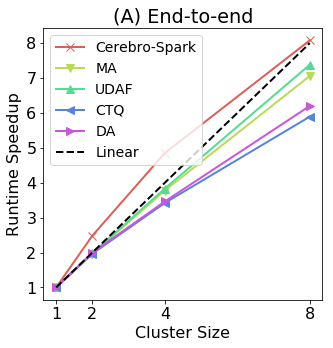

In [415]:


plot_scalability = PlotterBase(xlabel='Cluster Size', ylabel='Runtime Speedup', title='(A) End-to-end', set_ticks=True)


line_fmts = ['x-', 'v-', '^-', '<-', '>-' ]


for method, fmt in zip(methods, line_fmts):
    runtime = np.array(times[method])
    speedup = runtime[0] * 1.0 / runtime 
    plot_scalability.plot(size, speedup, fmt, label=method, markersize=8)
plot_scalability.plot(size, size, 'k--', label='Linear')
plot_scalability.ax.legend(fontsize=14)

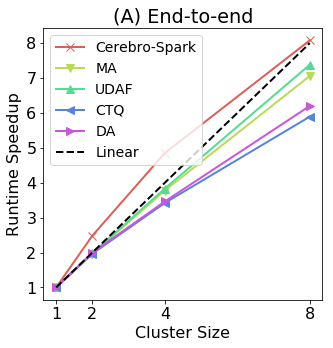

In [416]:
plot_scalability.fig

In [417]:
save_fig(plot_scalability.fig, 'scalability')

In [418]:
# Cerebro-Spark: 
# worker1: [par1, par2]
# worker2: [par3, par4]
# CTQ, MA, UDAF, DA:
# worker1: [par1*]
# worker2: [par2*]


In [419]:

size_exp_root_all = {
    'ctq':{1: '../logs/run_logs/scalability/2020_10_01_15_02_41/1/cerebro-ctq',
    2: '../logs/run_logs/scalability/2020_09_26_14_55_16/2/cerebro-ctq',
    4: '../logs/run_logs/scalability/2020_09_25_14_04_54/4/cerebro-ctq',
    8: '../logs/run_logs/scalability/2020_09_28_20_32_48/8/cerebro-ctq'},
    'ma':{1: '../logs/run_logs/scalability/2020_09_29_14_38_10/1/ma',
    2: '../logs/run_logs/scalability/2020_09_26_14_55_16/2/ma',
    4: '../logs/run_logs/scalability/2020_09_25_14_04_54/4/ma',
    8: '../logs/run_logs/scalability/2020_09_28_20_32_48/8/ma'},
    'udaf':{1: '../logs/run_logs/scalability/2020_09_29_14_38_10/1/cerebro',
    2: '../logs/run_logs/scalability/2020_09_26_14_55_16/2/cerebro',
    4: '../logs/run_logs/scalability/2020_09_25_14_04_54/4/cerebro',
    8: '../logs/run_logs/scalability/2020_09_28_20_32_48/8/cerebro'},
    'da':{1: '../logs/run_logs/scalability/2020_10_02_20_08_29/1/cerebro-da',
    2: '../logs/run_logs/scalability/2020_09_27_19_51_25/2/cerebro-da',
    4: '../logs/run_logs/scalability/2020_09_24_21_40_46/4/cerebro-da',
    8: '../logs/run_logs/scalability/2020_09_28_14_42_24/8/cerebro-da'},
    'spark':{1: '../logs/run_logs/scalability/cerebro/1',
    2: '../logs/run_logs/scalability/cerebro/2',
    4: '../logs/run_logs/scalability/cerebro/4',
    8: '../logs/run_logs/scalability/cerebro/8'},
}

size_segs_db = {
    1: [7],
    2: [0, 1],
    4: [0, 1, 2, 3],
    8: None,
}
size_segs_sa = {
    1: [0],
    2: [0, 1],
    4: [0, 1, 2, 3],
    8: None,
}
size_segs = {}
size_segs['udaf'] = size_segs_db
size_segs['ctq'] = size_segs_db
size_segs['ma'] = size_segs_db
size_segs['da'] = size_segs_sa
size_segs['spark'] = size_segs_sa

In [420]:
df_plot_dict = {}
dict_time_dict = defaultdict(dict)
for name, size_exp_root in size_exp_root_all.items():
    plot_list = []
    for size, exp_root in size_exp_root.items():
        print (size, exp_root)
        la = FakeLA(exp_root)
        segs = size_segs[name][size]
        method_name = 'standalone' if name in ['da', 'spark'] else name
        plot_time, dict_time = get_plot_time(la, segs, semantics[method_name], method_name)
        dict_time_dict[name][size] = dict_time
        plot_time['msize'] = size
        plot_list.append(plot_time)
    df_plot = pd.DataFrame(plot_list)
    df_plot_dict[name] = df_plot

1 ../logs/run_logs/scalability/2020_10_01_15_02_41/1/cerebro-ctq
2 ../logs/run_logs/scalability/2020_09_26_14_55_16/2/cerebro-ctq
4 ../logs/run_logs/scalability/2020_09_25_14_04_54/4/cerebro-ctq
8 ../logs/run_logs/scalability/2020_09_28_20_32_48/8/cerebro-ctq
1 ../logs/run_logs/scalability/2020_09_29_14_38_10/1/ma
2 ../logs/run_logs/scalability/2020_09_26_14_55_16/2/ma
4 ../logs/run_logs/scalability/2020_09_25_14_04_54/4/ma
8 ../logs/run_logs/scalability/2020_09_28_20_32_48/8/ma
1 ../logs/run_logs/scalability/2020_09_29_14_38_10/1/cerebro
2 ../logs/run_logs/scalability/2020_09_26_14_55_16/2/cerebro
4 ../logs/run_logs/scalability/2020_09_25_14_04_54/4/cerebro
8 ../logs/run_logs/scalability/2020_09_28_20_32_48/8/cerebro
1 ../logs/run_logs/scalability/2020_10_02_20_08_29/1/cerebro-da
2 ../logs/run_logs/scalability/2020_09_27_19_51_25/2/cerebro-da
4 ../logs/run_logs/scalability/2020_09_24_21_40_46/4/cerebro-da
8 ../logs/run_logs/scalability/2020_09_28_14_42_24/8/cerebro-da
1 ../logs/run_lo

In [421]:
df_events_grand = parse_all_events(la, segs, 'standalone')

df_propotion_time = df_events_grand.groupby('event').agg('sum').reset_index()[['event', 'time']]
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1): 
    display(df_propotion_time)

,event,time
0,Between-PRELOAD_COMPLETED-TRAIN_LAUNCHED,52.0
1,Between-TRAIN_COMPLETED-TRAIN_LAUNCHED,1786.0
2,Between-TRAIN_COMPLETED-VALID_LAUNCHED,2743.0
3,Between-TRAIN_LAUNCHED-TRAIN_COMPLETED,18970.0
4,Between-VALID_COMPLETED-VALID_LAUNCHED,116.0
5,Between-VALID_LAUNCHED-VALID_COMPLETED,636.0


In [422]:
df_plot_dict['udaf']['model_hopping'] += df_plot_dict['udaf']['data_transmission'] - df_plot_dict['ctq']['data_transmission']
df_plot_dict['ma']['model_hopping'] = df_plot_dict['ma']['data_transmission'] - df_plot_dict['ctq']['data_transmission']
df_plot_dict['udaf']['data_transmission'] = df_plot_dict['ctq']['data_transmission']
df_plot_dict['ma']['data_transmission'] = df_plot_dict['ctq']['data_transmission']
# df_plot_dict['udaf']['overhead'] = df_plot_dict['udaf']['model_hopping']
# df_plot_dict['ma']['overhead'] = df_plot_dict['ma']['merge'] + df_plot_dict['ma']['model_hopping']
# df_plot_dict['ctq']['overhead'] = df_plot_dict['ctq']['idle'] 
df_plot_dict['ctq']['train_valid']+= df_plot_dict['ctq']['initialization'] + df_plot_dict['ctq']['exiting']
df_plot_dict['ctq'] = df_plot_dict['ctq'][['data_transmission', 'model_hopping', 'train_valid', 'msize', 'idle']]
df_plot_dict['udaf']['train_valid']+= df_plot_dict['udaf']['initialization'] + df_plot_dict['udaf']['exiting']
df_plot_dict['udaf'] = df_plot_dict['udaf'][['data_transmission', 'model_hopping', 'train_valid', 'msize']]
df_plot_dict['ma']['train_valid']+= df_plot_dict['ma']['initialization'] + df_plot_dict['ma']['exiting']
df_plot_dict['ma'] = df_plot_dict['ma'][['data_transmission', 'model_hopping', 'train_valid', 'msize', 'merge']]
df_plot_dict['ma']
df_plot_dict['da']['model_hopping'] = df_plot_dict['ctq']['model_hopping']
df_plot_dict['da']['data_transmission'] = 0
df_plot_dict['da'] = df_plot_dict['da'][['data_transmission', 'model_hopping', 'train_valid', 'msize', 'idle']]
df_plot_dict['spark']['model_hopping'] = df_plot_dict['ctq']['model_hopping']
df_plot_dict['spark']['data_transmission'] = 0
df_plot_dict['spark'] = df_plot_dict['spark'][['data_transmission', 'model_hopping', 'train_valid', 'msize', 'idle']]

In [423]:
df_plot_dict['da']

,data_transmission,model_hopping,train_valid,msize,idle
0,0,4.0,35420.0,1,16.0
1,0,9.0,35424.0,2,602.0
2,0,8.0,36921.0,4,4774.0
3,0,23.0,40042.0,8,8064.0


In [424]:
df_plot_dict['spark']

,data_transmission,model_hopping,train_valid,msize,idle
0,0,4.0,26141.0,1,130.0
1,0,9.0,20005.0,2,221.0
2,0,8.0,19740.0,4,1410.0
3,0,23.0,19606.0,8,4697.0


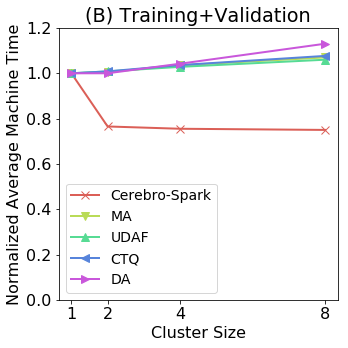

In [431]:
plot_scalability_drill = PlotterBase(xlabel='Cluster Size', ylabel='Normalized Average Machine Time', title='(B) Training+Validation', set_ticks=True)
methods_dict = {'Cerebro-Spark':'spark', 'MA':'ma', 'UDAF':'udaf', 'CTQ':'ctq', 'DA':'da'}


for method, fmt in zip(methods, line_fmts):
    df = df_plot_dict[methods_dict[method]]
    cluster_sizes = df['msize']
    train_valid = df['train_valid']
    plot_scalability_drill.plot(cluster_sizes, train_valid/train_valid[0], fmt, label=method, markersize=8)

plot_scalability_drill.ax.legend(fontsize=14)
plot_scalability_drill.ax.set_yticks(np.arange(0, 1.3, 0.2))
save_fig(plot_scalability_drill.fig, 'scalability_drill_down_train')

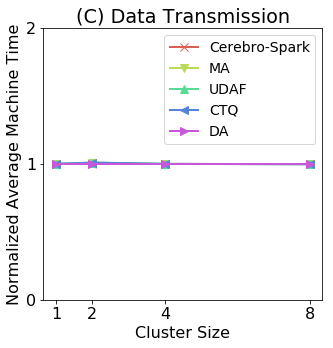

In [432]:
plot_scalability_drill = PlotterBase(xlabel='Cluster Size', ylabel='Normalized Average Machine Time', title='(C) Data Transmission', set_ticks=True)
methods_dict = {'Cerebro-Spark':'spark', 'MA':'ma', 'UDAF':'udaf', 'CTQ':'ctq', 'DA':'da'}


for method, fmt in zip(methods, line_fmts):
    df = df_plot_dict[methods_dict[method]]
    data_transmission = df['data_transmission']
    plot_scalability_drill.plot(cluster_sizes, (data_transmission/data_transmission[0]).fillna(1), fmt, label=method, markersize=8)

plot_scalability_drill.ax.set_yticks([0, 1, 2])

plot_scalability_drill.ax.legend(fontsize=14)
save_fig(plot_scalability_drill.fig, 'scalability_drill_down_data')




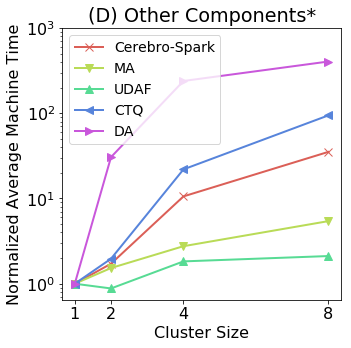

In [433]:
plot_scalability_drill = PlotterBase(xlabel='Cluster Size', ylabel='Normalized Average Machine Time', title='(D) Other Components*', set_ticks=True)


for method, fmt in zip(methods, line_fmts):
    df = df_plot_dict[methods_dict[method]]
    columns = df.columns
    columns = [column for column in columns if column not in ['msize', 'train_valid', 'data_transmission']]

    other = df[columns].sum(axis=1)
    plot_scalability_drill.plot(cluster_sizes, other/other[0], fmt, label=method, markersize=8)
plot_scalability_drill.ax.set_yscale('log')
plot_scalability_drill.ax.legend(fontsize=14)
plot_scalability_drill.ax.set_yticks([1, 10, 100, 1000])
save_fig(plot_scalability_drill.fig, 'scalability_drill_down_other')

In [434]:
??save_fig

In [ ]:
# df_events_grand = parse_all_events(la, segs, name)
# df_propotion_time = df_events_grand.groupby('event').agg('sum').reset_index()[['event', 'time']]
# with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', -1): 
#     display(df_propotion_time)

### End-to-end Breakdown

#### Criteo

In [396]:
palette = ['#2B3A67', '#FFFD82', '#FF9B71', '#C14953']

size_exp_root_all = {
    'ctq':'../logs/run_logs/2020_10_19_18_33_55/cerebro-ctq',
    'ma':'../logs/run_logs/2020_10_21_13_58_50/ma',
    'udaf':'../logs/run_logs/2020_10_15_10_54_12/cerebro',
    'da':'../logs/run_logs/2020_10_14_03_31_04/cerebro-da',
    'spark':'../logs/run_logs/2020_10_18_04_02_57/e2e_filesystem_cerebro_standalone',
}


df_plot_dict = {}
dict_time_dict = {}
plot_list = []
for name, exp_root in size_exp_root_all.items():
    print (name, exp_root)
    la = FakeLA(exp_root)
    method_name = 'standalone' if name in ['da', 'spark'] else name
    plot_time, dict_time = get_plot_time(la, None, semantics[method_name], method_name)
    dict_time_dict[name] = dict_time
    plot_time['name'] = name
    plot_list.append(plot_time)
        


ctq ../logs/run_logs/2020_10_19_18_33_55/cerebro-ctq
ma ../logs/run_logs/2020_10_21_13_58_50/ma
udaf ../logs/run_logs/2020_10_15_10_54_12/cerebro
da ../logs/run_logs/2020_10_14_03_31_04/cerebro-da
spark ../logs/run_logs/2020_10_18_04_02_57/e2e_filesystem_cerebro_standalone


In [397]:
df_plot.sum(axis=1)/3600/8

name
spark    0.000080
ma       0.000153
udaf     0.000166
ctq      0.000144
da       0.000080
dtype: float64

Text(0.5, 1.0, '(C) Per-epoch Runtimes Breakdown (Criteo)')

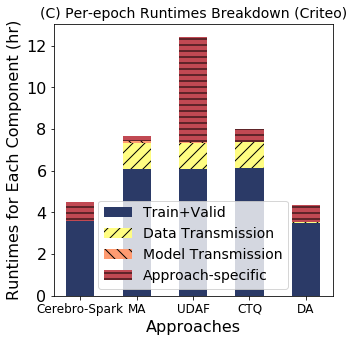

In [398]:
df_plot = pd.DataFrame(plot_list)


df_plot = df_plot.fillna(0)

df_plot['train_valid'] += df_plot['exiting'] + df_plot['initialization']
df_plot = df_plot[[x for x in df_plot.columns if x not in ['exiting', 'initialization']]]

df_plot = df_plot.set_index('name')
df_plot.at['udaf', 'model_hopping'] += df_plot.loc['udaf']['data_transmission'] - df_plot.loc['ctq']['data_transmission']
# from model size tests

udaf_model_hopping = 0.081667 * 3600 * 8 
df_plot.at['udaf', 'idle'] = df_plot.loc['udaf']['model_hopping'] - udaf_model_hopping
df_plot.at['udaf', 'model_hopping'] = udaf_model_hopping
df_plot.at['ma', 'model_hopping'] = df_plot.loc['ma']['data_transmission'] - df_plot.loc['ctq']['data_transmission']
df_plot.at['udaf', 'data_transmission'] = df_plot.loc['ctq']['data_transmission']
df_plot.at['ma', 'data_transmission'] = df_plot.loc['ctq']['data_transmission']
df_plot.at['udaf', 'data_transmission'] = df_plot.loc['ctq']['data_transmission']
df_plot.at['ma', 'data_transmission'] = df_plot.loc['ctq']['data_transmission']
df_plot.at['spark', 'data_transmission'] = 118 * 8
df_plot.at['da', 'data_transmission'] = 118 * 8
df_plot.loc[['da', 'spark'], 'train_valid'] -= df_plot.loc[['da', 'spark'], 'data_transmission']


df_epochs = df_plot.loc[['da', 'spark']]
df_epochs[['idle', 'train_valid']]
df_plot.loc[['da', 'spark']] = df_epochs
df_plot.loc[['da', 'spark'], 'model_hopping'] = df_plot.loc['ctq', 'model_hopping']
df_plot.loc[['da', 'spark'], 'train_valid'] -= df_plot.loc[['da', 'spark'], 'model_hopping']
df_plot = (df_plot/8/3600)
df_plot = df_plot.reindex(ordered_methods_indices)

df_plot /= 5
title = '(C) Per-epoch Runtimes Breakdown (Criteo)'
plot_breakdown = PlotterBase(xlabel='Approaches', ylabel='Runtimes for Each Component (hr)', title=title, set_ticks=False)

index = range(len(methods))
fields = ['train_valid', 'data_transmission', 'model_hopping', 'method_specific']
names = ['Train+Valid', 'Data Transmission', 'Model Transmission', 'Approach-specific']
hatches = [None, '//', '\\\\', '--']

bar_width = 0.5


prev_bottom = pd.Series(0, index=ordered_methods_indices)
for field, name, color, hatch in zip(fields, names, palette, hatches):
    if field == 'method_specific':
        series_plot = df_plot['idle'] + df_plot['merge']
    else:
        series_plot = df_plot[field]
    
    plot_breakdown.ax.bar(index, series_plot, bar_width,color=color, label=name, bottom=prev_bottom, hatch=hatch)
    prev_bottom += series_plot
plot_breakdown.ax.set_xticks(index)
plot_breakdown.ax.set_xticklabels(methods, fontsize=12)
plot_breakdown.ax.set_yticks(range(14)[::2])
plot_breakdown.ax.legend(fontsize=14, loc='lower center')
plot_breakdown.ax.set_title(title, fontsize=14)

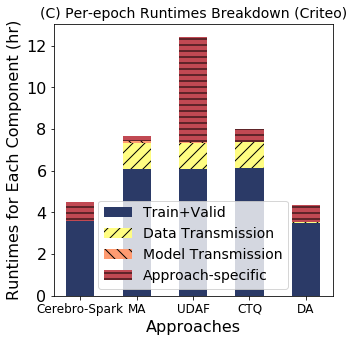

In [399]:
plot_breakdown.fig

In [400]:
save_fig(plot_breakdown.fig, 'e2e_breakdown_criteo')

#### ImageNet

In [401]:
palette = ['#2B3A67', '#FFFD82', '#FF9B71', '#C14953']

size_exp_root_all = {
    'ctq':'../logs/run_logs/2020_10_06_19_40_24/cerebro-ctq',
    'ma':'../logs/run_logs/2020_10_05_00_23_36/ma',
    'udaf':'../logs/run_logs/2020_10_05_00_23_36/cerebro',
    'da':'../logs/run_logs/2020_08_14_16_08_52/e2e_da_cerebro_standalone',
    'spark':'../logs/run_logs/2020_08_12_17_22_58/e2e_filesystem_cerebro_standalone',
}


df_plot_dict = {}
dict_time_dict = {}
plot_list = []
for name, exp_root in size_exp_root_all.items():
    print (name, exp_root)
    la = FakeLA(exp_root)
    method_name = 'standalone' if name in ['da', 'spark'] else name
    plot_time, dict_time = get_plot_time(la, None, semantics[method_name], method_name)
    dict_time_dict[name] = dict_time
    plot_time['name'] = name
    plot_list.append(plot_time)
        
df_plot = pd.DataFrame(plot_list)


df_plot = df_plot.fillna(0)

df_plot['train_valid'] += df_plot['exiting'] + df_plot['initialization']
df_plot = df_plot[[x for x in df_plot.columns if x not in ['exiting', 'initialization']]]

df_plot = df_plot.set_index('name')

ctq ../logs/run_logs/2020_10_06_19_40_24/cerebro-ctq
ma ../logs/run_logs/2020_10_05_00_23_36/ma
udaf ../logs/run_logs/2020_10_05_00_23_36/cerebro
da ../logs/run_logs/2020_08_14_16_08_52/e2e_da_cerebro_standalone
spark ../logs/run_logs/2020_08_12_17_22_58/e2e_filesystem_cerebro_standalone


In [402]:
df_plot.sum(axis=1)/3600/8

name
ctq       4.143125
ma        4.406146
udaf      4.775799
da       23.011493
spark    22.865035
dtype: float64

In [403]:
df_plot.at['udaf', 'model_hopping'] += df_plot.loc['udaf']['data_transmission'] - df_plot.loc['ctq']['data_transmission']
# from model size tests

udaf_model_hopping = (0.194919 + 0.123553) * 3600 * 8/2. 
df_plot.at['udaf', 'idle'] = df_plot.loc['udaf']['model_hopping'] - udaf_model_hopping
df_plot.at['udaf', 'model_hopping'] = udaf_model_hopping
df_plot.at['ma', 'model_hopping'] = df_plot.loc['ma']['data_transmission'] - df_plot.loc['ctq']['data_transmission']
df_plot.at['udaf', 'data_transmission'] = df_plot.loc['ctq']['data_transmission']
df_plot.at['ma', 'data_transmission'] = df_plot.loc['ctq']['data_transmission']
df_plot.at['udaf', 'data_transmission'] = df_plot.loc['ctq']['data_transmission']
df_plot.at['ma', 'data_transmission'] = df_plot.loc['ctq']['data_transmission']
df_plot.at['spark', 'data_transmission'] = 32 * 8
df_plot.at['da', 'data_transmission'] = 32 * 8
df_plot.loc[['da', 'spark'], 'train_valid'] -= df_plot.loc[['da', 'spark'], 'data_transmission']


df_10epochs = df_plot.loc[['da', 'spark']]
df_10epochs[['idle', 'train_valid']] /= 10 
df_plot.loc[['da', 'spark']] = df_10epochs
df_plot.loc[['da', 'spark'], 'model_hopping'] = df_plot.loc['ctq', 'model_hopping']
df_plot.loc[['da', 'spark'], 'train_valid'] -= df_plot.loc[['da', 'spark'], 'model_hopping']
df_plot = (df_plot/8/3600)
df_plot = df_plot.reindex(ordered_methods_indices)

In [404]:
df_plot.sum(axis = 1)

name
spark    2.294503
ma       4.406146
udaf     4.775799
ctq      4.143125
da       2.309149
dtype: float64

In [405]:
df_plot

,data_transmission,idle,model_hopping,train_valid,merge
name,,,,,
spark,0.008889,0.172872,0.001840,2.110903,0.000000
ma,1.050104,0.000000,0.072917,2.863576,0.419549
udaf,1.050104,0.676840,0.159236,2.889618,0.000000
ctq,1.050104,0.138854,0.001840,2.952326,0.000000
da,0.008889,0.187670,0.001840,2.110750,0.000000


Text(0.5, 1.0, '(B) Per-epoch Runtimes Breakdown (ImageNet)')

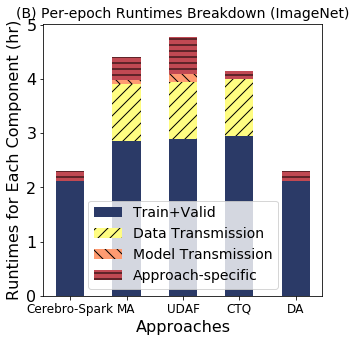

In [406]:
title = '(B) Per-epoch Runtimes Breakdown (ImageNet)'
plot_breakdown = PlotterBase(xlabel='Approaches', ylabel='Runtimes for Each Component (hr)', title=title, set_ticks=False)

index = range(len(methods))
fields = ['train_valid', 'data_transmission', 'model_hopping', 'method_specific']
names = ['Train+Valid', 'Data Transmission', 'Model Transmission', 'Approach-specific']
hatches = [None, '//', '\\\\', '--']

bar_width = 0.5


prev_bottom = pd.Series(0, index=ordered_methods_indices)
for field, name, color, hatch in zip(fields, names, palette, hatches):
    if field == 'method_specific':
        series_plot = df_plot['idle'] + df_plot['merge']
    else:
        series_plot = df_plot[field]
    
    plot_breakdown.ax.bar(index, series_plot, bar_width,color=color, label=name, bottom=prev_bottom, hatch=hatch)
    prev_bottom += series_plot
plot_breakdown.ax.set_xticks(index)
plot_breakdown.ax.set_xticklabels(methods, fontsize=12)
plot_breakdown.ax.set_yticks(range(6))
plot_breakdown.ax.legend(fontsize=14)
plot_breakdown.ax.set_title(title, fontsize=14)




In [407]:
save_fig(plot_breakdown.fig, 'e2e_breakdown')

In [408]:
series_plot

name
spark    0.172872
ma       0.419549
udaf     0.676840
ctq      0.138854
da       0.187670
dtype: float64

In [1259]:
# model_logs = glob.glob(os.path.join(size_exp_root_all['spark'], '*.log'))
# model_logs = sorted([x for x in model_logs if os.path.basename(x).split('.')[0].isnumeric()])
# model_logs = sorted(model_logs, key=len)

# line_dicts = []
# for model_log_dir in model_logs:
#     lines = readlines(model_log_dir)
#     lines = [line for line in lines if 'PARTITION: ' in line]

    
#     for line in lines:
#         line_dict = dict([x.split(': ') for x in line.split(', ')])
#         line_dicts.append(line_dict)
# df = pd.DataFrame(line_dicts)

# df.loc[df['Model Building and Session Initialization Time'].notnull(), 'EVENT'] = 'Model Building and Session Initialization'
# df.loc[df['Checkpoint Save Time'].notnull(), 'EVENT'] = 'Checkpoint Save'
# df.loc[df['Checkpoint Save Time'].notnull(), 'EVENT'] = 'Checkpoint Save'